# K- Nearest Neighbor Regression
This notebooks brings the concept of using Regression Analysis in association with KNN. 

This algorithm gets the **k** nearest results for that regression and creates an average to get to the final result, making a possibly more robust solution.

## Imports

In [26]:
# Data Manipulation
import pandas as pd
import numpy as np

# DataViz
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_squared_error

## Dataset

In [2]:
# Load and view dataset
df = sns.load_dataset('diamonds')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
# Data shape
print(f'Number of rows: {df.shape[0]} | Columns (variables): {df.shape[1]}')

Number of rows: 53940 | Columns (variables): 10


## Data Exploration

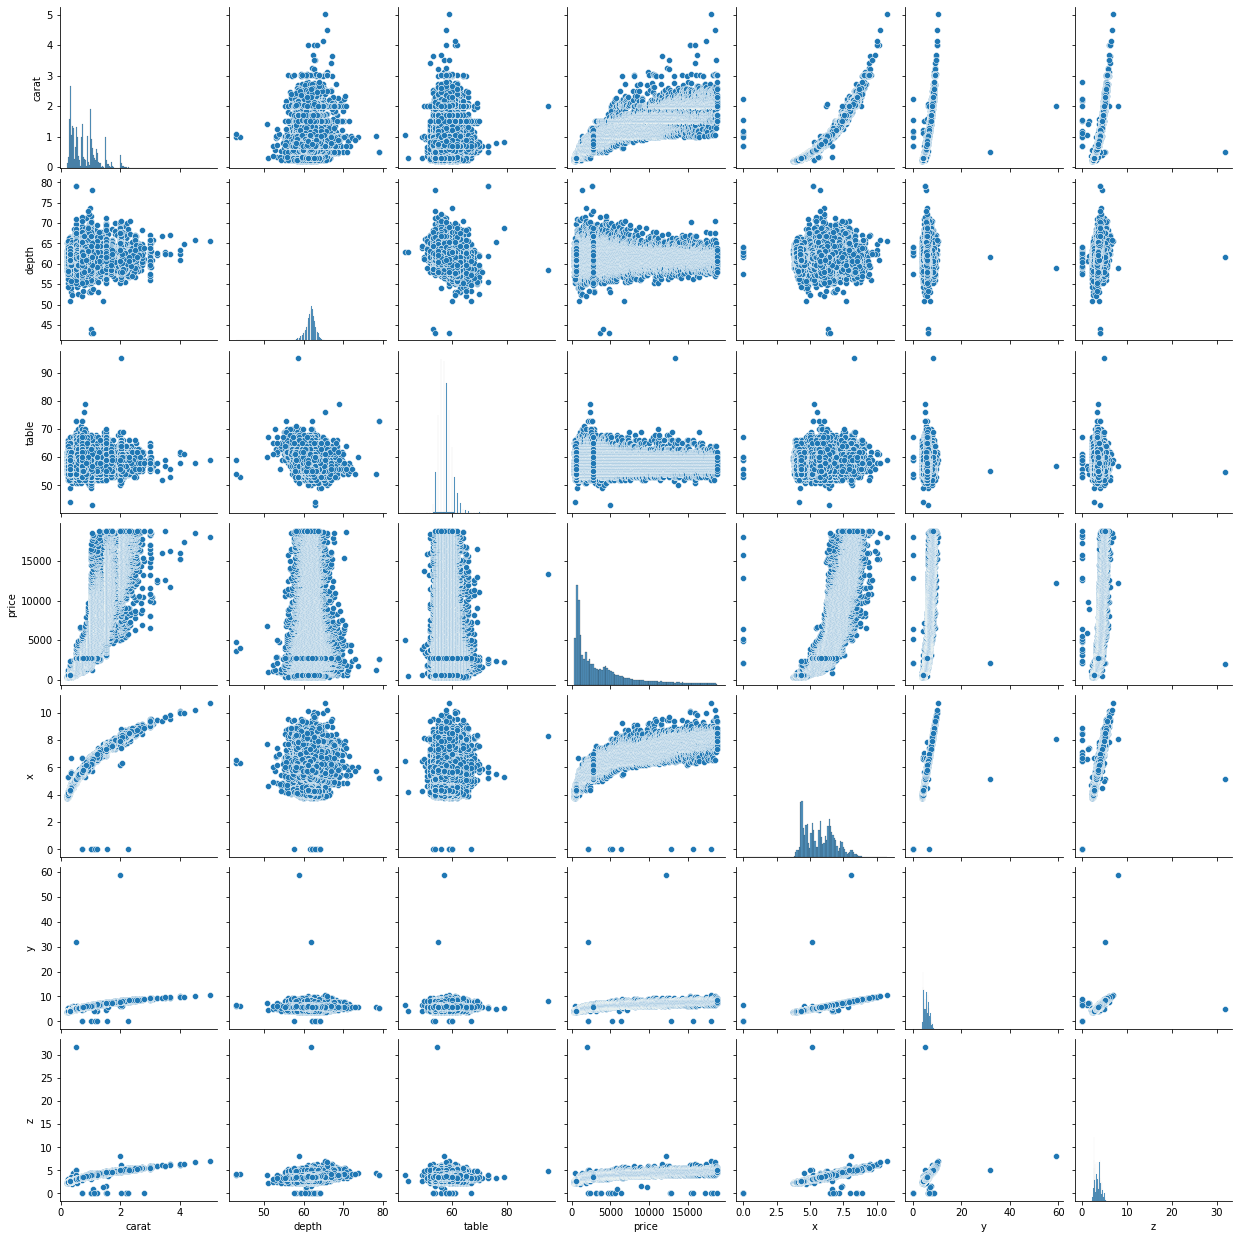

In [4]:
# Let's see the possible best variables for modeling the carat
sns.pairplot(df);

In [5]:
df.corr().style.background_gradient(cmap='coolwarm')

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


`Analysis`: Let's use the X, Y and Z information to model *carrat*. As per the pairplot and the correlations table above, we see that Y and Z have an apparent linear relationship with the  target variable, while X shows an exponential curve. We will address that.

## Missing Values

In [6]:
# Checking for missing values
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

No missing values found. Let's move on.

## Train Test Split

In order to prevent *data leakage* (when components of the training dataset leak to the response variable and influences the model fitting, creating a wrong sensation of good fit), we're spliting the data now, before any other formatting.

In [7]:
X = df[['x', 'y', 'z']]
y = df.carat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=12)

In [8]:
print(f'Train: {X_train.shape, y_train.shape}  \nTest: {X_test.shape, y_test.shape}')

Train: ((43152, 3), (43152,))  
Test: ((10788, 3), (10788,))


## Removing Outliers

Linear Regression is very affected by outliers, as it can interfere in the curve slope calculation. 

Let's remove those using the 1.5 x IQR rule: everything above or below 1.5 times the inter-quantile range will be removed.

In [9]:
# Extract the descriptive statistics for the explanatory variables for IQR calculation
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
x,43152.0,5.731283,1.122783,0.0,4.71,5.69,6.54,10.74
y,43152.0,5.734739,1.150275,0.0,4.72,5.71,6.54,58.90
z,43152.0,3.538536,0.708813,0.0,2.91,3.53,4.03,31.80


In [10]:
# Extracting the quantiles
x_25 = X_train.describe().T.loc['x', '25%']
x_75 = X_train.describe().T.loc['x', '75%']
y_25 = X_train.describe().T.loc['y', '25%']
y_75 = X_train.describe().T.loc['y', '75%']
z_25 = X_train.describe().T.loc['z', '25%']
z_75 = X_train.describe().T.loc['z', '75%']

# Calculate IQRs
IQR_x = 1.5 * (x_75 - x_25)
IQR_y = 1.5 * (y_75 - y_25)
IQR_z = 1.5 * (z_75 - z_25)

Remove the Outliers

In [11]:
# Remove outliers from the variable 'x'
X_train = X_train.query(' x >= (@x_25 - @IQR_x) & x <= (@x_75 + @IQR_x) ')
y_train = y_train[X_train.index]

# Remove outliers from the variable 'y'
X_train = X_train.query(' z >= (@y_25 - @IQR_y) & y <= (@y_75 + @IQR_y) ')
y_train = y_train[X_train.index]

# Remove outliers from the variable 'z'
X_train = X_train.query(' x >= (@z_25 - @IQR_z) & z <= (@z_75 + @IQR_z) ')
y_train = y_train[X_train.index]

Check the results : Clean dataset

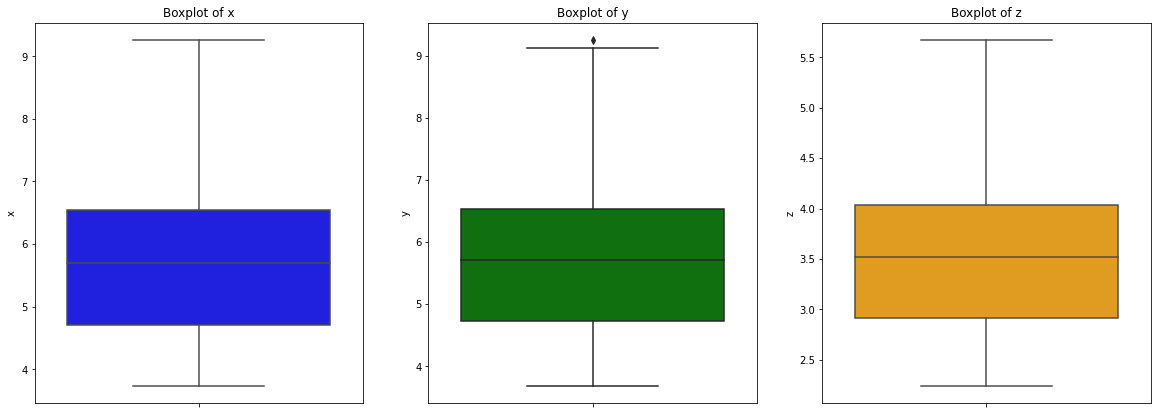

In [12]:
# setup figure
fig, ax = plt.subplots(1,3, figsize=(20,7))

# plot1
g1 = sns.boxplot(y=X_train.x, color='blue', ax=ax[0])
g1.set_title('Boxplot of x')

# plot2
g2 = sns.boxplot(y=X_train.y, color='green', ax=ax[1])
g2.set_title('Boxplot of y')

# plot3
g3 = sns.boxplot(y=X_train.z, color='orange', ax=ax[2])
g3.set_title('Boxplot of z');

Let's see the scatteplots now that we have removed the outliers

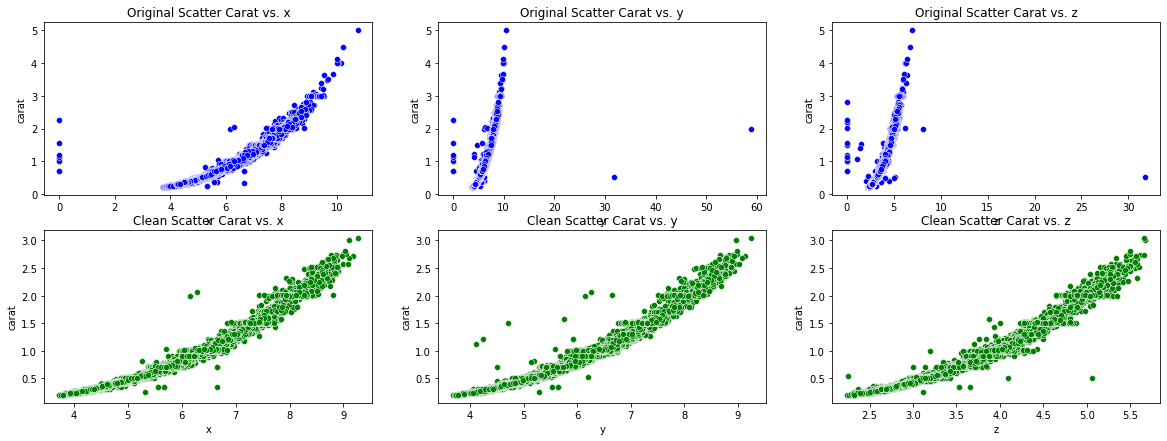

In [13]:
# setup figure
fig, ax = plt.subplots(2,3, figsize=(20,7))

for i, var in enumerate(['x', 'y', 'z']):
  # Original data plots
  g= sns.scatterplot(data= df, x=var, y='carat', color='blue', ax=ax[0][i])
  g.set_title(f'Original Scatter Carat vs. {var}')


df_clean = pd.concat([X_train, y_train], axis=1)

for i, var in enumerate(['x', 'y', 'z']):
  # Cleaned data plots
  g= sns.scatterplot(data= df_clean, x=var, y='carat', color='green', ax=ax[1][i])
  g.set_title(f'Clean Scatter Carat vs. {var}')

We see that the relationships are almost linear, but they have a little curve, what's some exponential degree that could be linearized using a log transformation.

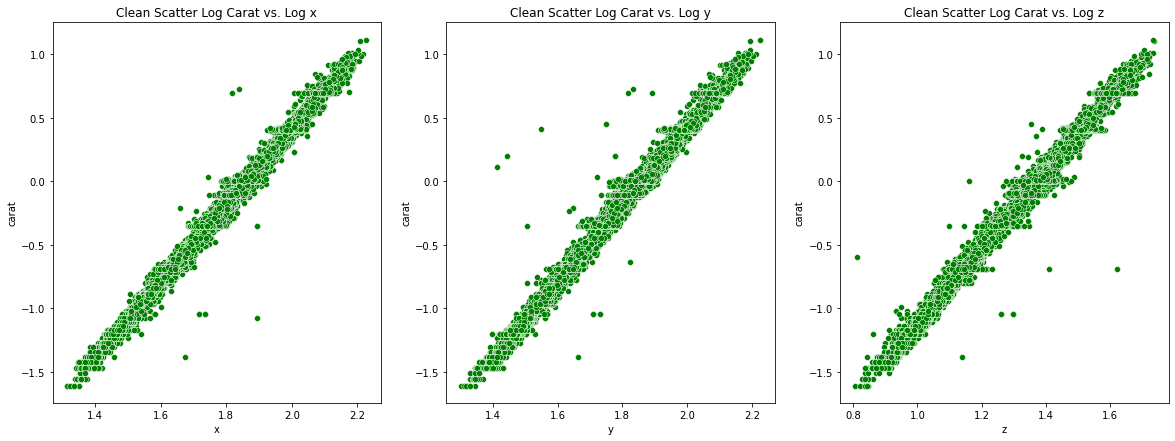

In [14]:
# setup figure
fig, ax = plt.subplots(1,3, figsize=(20,7))

for i, var in enumerate(['x', 'y', 'z']):
  log_var = np.log(df_clean[var])
  # Cleaned data plots
  g= sns.scatterplot(x=log_var, y= np.log(df_clean.carat), color='green', ax=ax[i]);
  g.set_title(f'Clean Scatter Log Carat vs. Log {var}');

The linear relationship is much better after a log transformation. So let's do that prior to modeling.

In [15]:
# Log transformation
X_log = np.log(X_train)
y_log = np.log(y_train)

## Modeling

### Linear Regression

In [16]:
# Instance and fit
lr_model = LinearRegression().fit(X_train, y_train)

# Score
lr_model.score(X_test, y_test)

0.9534250731184013

In [40]:
# Predictions
preds_lr = lr_model.predict(X_test)

# RMSE
rmse_lr = round( mean_squared_error(y_test, preds_lr), 5 )
rmse_lr

0.01031

### Linear Regression with Log Transformation

In [17]:
# Instance and fit
lrLog_model = LinearRegression().fit(X_log, y_log)

# Remove zeroes
X_test_log = X_test[(X_test.x > 0) & (X_test.y > 0) & (X_test.z > 0) ]
y_test_log = y_test[X_test_log.index]

# Log Transform X_test and y test
X_test_log = np.log(X_test_log)
y_test_log = np.log(y_test_log)

# Score
lrLog_model.score(X_test_log, y_test_log)

0.9988479198247474

In [43]:
# Predictions
preds_log = lrLog_model.predict(X_test_log)

# RMSE
rmse_log = round( mean_squared_error(y_test_log, preds_log), 4)
print( f'---------------\nRMSE_ Log model:\n {rmse_log}\n---------------\n')

# Performance
pd.DataFrame({ 'True Value': np.exp(y_test_log),
               'Prediction': np.exp(preds_log)}).head(5)

---------------
RMSE_ Log model:
 0.0004
---------------



,True Value,Prediction
45936,0.51,0.517710
23023,0.35,0.348205
34325,0.39,0.391145
38578,0.40,0.403460
15979,1.20,1.225848


### KNN Regression



In [19]:
# Instance and fit
knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

# Score
knn_model.score(X_test, y_test)

0.9978517407802342

In [44]:
# Predictions
preds_knn = knn_model.predict(X_test)

# RMSE
rmse_knn = round( mean_squared_error(y_test, preds_knn), 4)
print( f'---------------\nRMSE_ KNN Model:\n {rmse_knn}\n---------------\n')


# Performance
performance = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': preds_knn,
                            'Error': y_test - preds_knn})
# View
performance

---------------
RMSE_ KNN Model:
 0.0005
---------------



,True Value,Prediction,Error
45936,0.51,0.516,-0.006
23023,0.35,0.348,0.002
34325,0.39,0.396,-0.006
38578,0.40,0.400,0.000
15979,1.20,1.220,-0.020
...,...,...,...
2106,0.90,0.900,0.000
18207,1.25,1.258,-0.008
37536,0.40,0.406,-0.006
5815,0.73,0.722,0.008


## Model Evaluation

In [47]:
# Comparison of the models
pd.DataFrame({'Model':['Linear Regression', 'LR with Log', 'KNN Regression'],
              'RMSE': [rmse_lr, rmse_log, rmse_knn]})

,Model,RMSE
0,Linear Regression,0.01031
1,LR with Log,0.00040
2,KNN Regression,0.00050


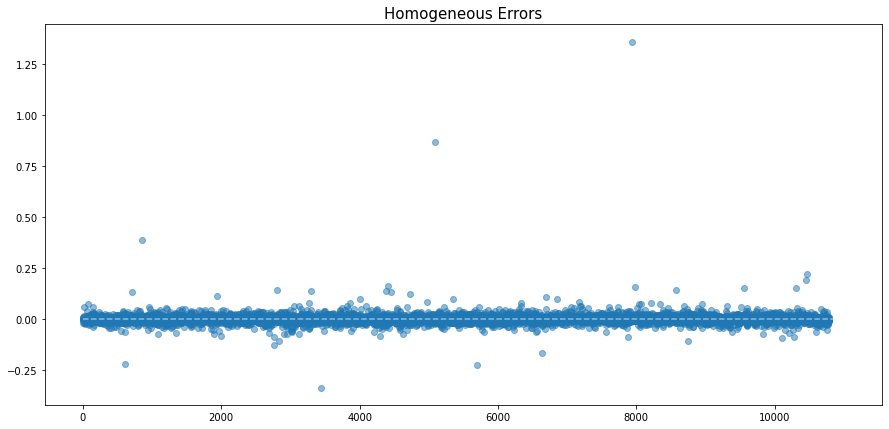

In [21]:
plt.figure(figsize=(15,7))
# Errors
ax_x= performance['True Value']
ax_y= performance['Prediction']
yerr= performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors', size=15);
plt.hlines(y=0, xmin=0, xmax=11000, linestyle='--', color='white', alpha=.5);
#plt.ylim(-.3, .3);

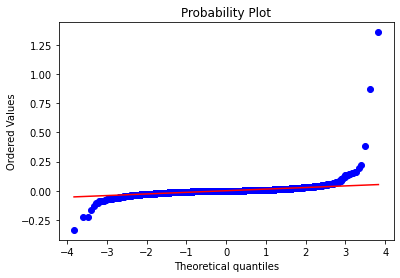

In [22]:
from scipy.stats import probplot
#QQ Plot
probplot(yerr, dist='norm', plot=plt);

The model presents some outliers, but most of the predictions are good. It should be enhanced with a little more clenup in the data, though.

In [23]:
# Predictions
preds = lrLog_model.predict(X_test_log)

# Performance
LR_log_performance = pd.DataFrame({ 'True Value': np.exp(y_test_log),
                                   'Prediction': np.exp(preds),
                                   'Error': np.exp(y_test_log) - np.exp(preds)})

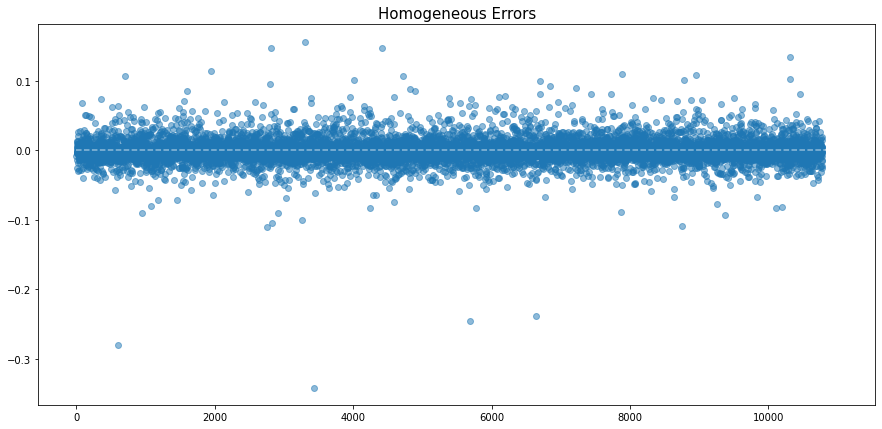

In [24]:
plt.figure(figsize=(15,7))
# Errors
ax_x= LR_log_performance['True Value']
ax_y= LR_log_performance['Prediction']
yerr= LR_log_performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors', size=15);
plt.hlines(y=0, xmin=0, xmax=11000, linestyle='--', color='white', alpha=.5);
#plt.ylim(-.3, .3);

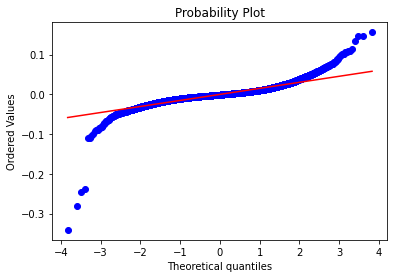

In [25]:
# QQ Plot
probplot(yerr, dist='norm', plot=plt);

The model with Log transformation also has a couple of wrong predictions too on the lower side, but it looks even better than the KNN model.